# Automated Defect Detection using Image Recognition in Manufacturing


This project aims to use image recognition techniques to detect defects in manufacturing products. The model will learn to classify images into different categories, such as "defect" or "non-defect." My ideas are to use image recognition techniques to automate defect detection in manufacturing, with the positive being increased productivity and cost-effectiveness, and the negative being potential errors in classification.

Import Libraries

In [57]:
# Data Analysis and Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2


#pre-processing 
from keras.preprocessing.image import ImageDataGenerator

#CNN
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping




Importing data from local directory and show examples of defect and non-defect items

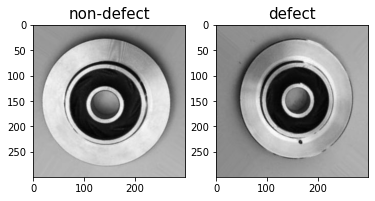

In [58]:
train_data_dr ='C:\\Users\\serca\\OneDrive\\Masaüstü\\IU Msc Computer Science\\Project Computer Science Project\\Python\\casting_data\\casting_data\\train\\'
test_data_dr = 'C:\\Users\\serca\\OneDrive\\Masaüstü\\IU Msc Computer Science\\Project Computer Science Project\\Python\\casting_data\\casting_data\\test\\'

ok = plt.imread(train_data_dr + "nondef\\cast_ok_0_1.jpeg")
plt.subplot(1, 2, 1)
plt.title("non-defect", size=15)
plt.imshow(ok)

defect = plt.imread(train_data_dr + "defect\\cast_def_0_11.jpeg")
plt.subplot(1, 2, 2)
plt.imshow(defect)
plt.title("defect", size=15)

plt.show()

Show the number of data in each class

In [59]:
# listdir() provides a list containing the names of the elements in the path-specified directory.
train_ok = len(os.listdir(train_data_dr + 'nondef'))
train_def = len(os.listdir(train_data_dr + 'defect'))
total_train = train_ok + train_def
train_data = [train_ok,train_def,total_train]
test_ok = len(os.listdir(test_data_dr + 'nondef'))
test_def = len(os.listdir(test_data_dr + 'defect'))
total_test = test_ok + test_def
test_data = [test_ok,test_def, total_test]

data = {"Train Data" : train_data, "Test Data": test_data}
df = pd.DataFrame(data)
index = ["OK", "Defect", "Total"]
df.index = index
df['Total'] = df.apply(lambda row: row['Train Data'] + row['Test Data'], axis=1)
df

,Train Data,Test Data,Total
OK,2875,262,3137
Defect,3758,453,4211
Total,6633,715,7348


Preprocess the images and leave 10% of train dataset for validation

In [60]:
#rescale data

train_scaled = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
    train_data_dr,
    subset="training",
    color_mode="grayscale",
    batch_size=32,
    target_size=(300,300), #input images
    class_mode= "binary"#there are two classes
)

validation_scaled = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
    train_data_dr,
    subset="validation",
    color_mode="grayscale",
    batch_size=32,
    target_size=(300,300), #input images
    class_mode= "binary"#there are two classes
)

test_scaled = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_dr,
    batch_size=32,
    color_mode="grayscale",
    target_size=(300,300), #input images
    class_mode= "binary", #there are two classes
    shuffle=False
)

#When evaluating the performance of your model on validation or testing data, it is generally recommended to set shuffle to False. 
#This ensures that the order of samples remains consistent during evaluation, allowing for fair comparison and consistent results.

Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


Implementation of our CNN model

In [61]:
output_size = 1 #binary classification
hidden_layer_size = 128 #hidden layers

model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, #convolutional layer
               strides = 2, activation = "relu",
               input_shape = [300,300,1]),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2), #pooling layer
        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, #2nd convolutional layer
               strides = 2, activation = "relu",
               input_shape = [300,300,1]),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),   #pooling layer 
        tf.keras.layers.Flatten(), #flatten the shape into a vector
        tf.keras.layers.Dense(hidden_layer_size, activation="relu"), #create 1st hidden layer
        tf.keras.layers.Dropout(rate=0.3), #regularization to prevent overfitting
        tf.keras.layers.Dense(hidden_layer_size, activation="relu"), #create 2nd hidden layer
        tf.keras.layers.Dropout(rate=0.3),#regularization to prevent overfitting
        tf.keras.layers.Dense(output_size, activation="sigmoid")#output layer
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 20736)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

Choose the optimizer and the loss function

In [62]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) #configure the model for training


Training the model ( we fit the model and see if actually works)

In [63]:
num_epochs = 25
check = ModelCheckpoint("model.h5", monitor = 'val_loss', save_best_only=True)#save the model's weights during training
e_stop = EarlyStopping(patience=3, restore_best_weights=True,  monitor = 'val_loss')#stop the training process early if the monitored metric does not improve

model_fit = model.fit(train_scaled, epochs=num_epochs,validation_data=validation_scaled,verbose=2,callbacks = [check, e_stop])

Epoch 1/25
187/187 - 55s - loss: 0.5844 - accuracy: 0.6662 - val_loss: 0.4701 - val_accuracy: 0.7356 - 55s/epoch - 294ms/step
Epoch 2/25
187/187 - 55s - loss: 0.3517 - accuracy: 0.8434 - val_loss: 0.1917 - val_accuracy: 0.9048 - 55s/epoch - 293ms/step
Epoch 3/25
187/187 - 55s - loss: 0.2216 - accuracy: 0.9009 - val_loss: 0.1340 - val_accuracy: 0.9486 - 55s/epoch - 293ms/step
Epoch 4/25
187/187 - 55s - loss: 0.1702 - accuracy: 0.9308 - val_loss: 0.1548 - val_accuracy: 0.9486 - 55s/epoch - 296ms/step
Epoch 5/25
187/187 - 56s - loss: 0.1158 - accuracy: 0.9534 - val_loss: 0.1105 - val_accuracy: 0.9502 - 56s/epoch - 300ms/step
Epoch 6/25
187/187 - 57s - loss: 0.1015 - accuracy: 0.9613 - val_loss: 0.1401 - val_accuracy: 0.9335 - 57s/epoch - 307ms/step
Epoch 7/25
187/187 - 55s - loss: 0.1119 - accuracy: 0.9556 - val_loss: 0.0877 - val_accuracy: 0.9607 - 55s/epoch - 293ms/step
Epoch 8/25
187/187 - 58s - loss: 0.0653 - accuracy: 0.9767 - val_loss: 0.0578 - val_accuracy: 0.9819 - 58s/epoch - 309

Plot loss and accuracy curves

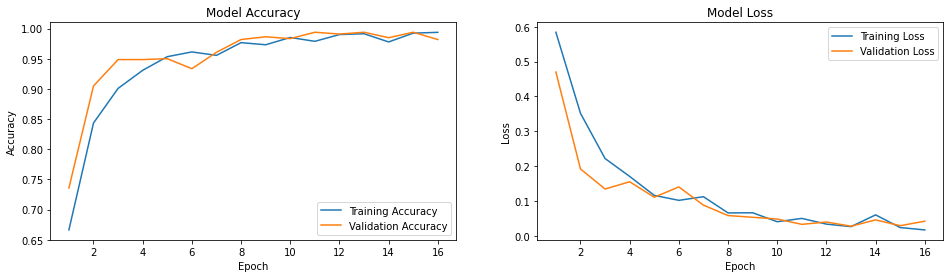

In [64]:
# Get accuracy and loss values from the training history
train_accuracy = model_fit.history['accuracy']
val_accuracy = model_fit.history['val_accuracy']
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

#plot accuracy and loss
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracy)+1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_accuracy)+1), val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Test the model on the data that model never seen

In [65]:
test_loss, test_accuracy = model.evaluate(test_scaled) #evaluate the model on the test dataset
print("Test loss:"+str(round(test_loss,2)))
print("Test accuracy:"+str(round(test_accuracy,2))+"%")

23/23 [==============================] - 2s 92ms/step - loss: 0.0224 - accuracy: 0.9916
Test loss:0.02
Test accuracy:0.99%


In [66]:
# Predict  from the Test dataset
pred_probability = model.predict(test_scaled)

# Seperate in ok and def
pred_class = (pred_probability > 0.5).reshape(-1,)

# True classes
true_class = test_scaled.classes

23/23 [==============================] - 2s 90ms/step


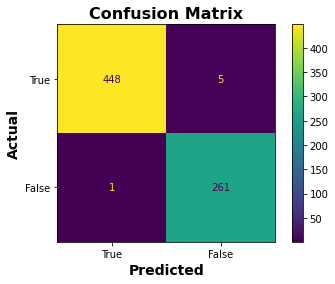

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Calculate the confusion matrix

cm = confusion_matrix(true_class, pred_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, False])
cm_display.plot()

plt.title("Confusion Matrix",size=16, weight="bold")
plt.ylabel("Actual", size=14, weight="bold")
plt.xlabel("Predicted", size=14, weight="bold")
plt.show()


In [69]:
print(classification_report(test_scaled.classes, pred_class, digits=4))

              precision    recall  f1-score   support

           0     0.9978    0.9890    0.9933       453
           1     0.9812    0.9962    0.9886       262

    accuracy                         0.9916       715
   macro avg     0.9895    0.9926    0.9910       715
weighted avg     0.9917    0.9916    0.9916       715



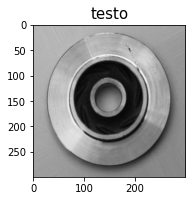

In [76]:
testing = plt.imread(test_data_dr + "defect\\cast_def_0_7.jpeg")
plt.subplot(1, 2, 2)
plt.imshow(testing)
plt.title("testo", size=15)

plt.show()

In [102]:
image_shape= (300,300,1)
plt.figure(figsize=(20,8))
img_pred = plt.imread(test_data_dr + "defect\\cast_def_0_160.jpeg", cv2.IMREAD_GRAYSCALE)
img_pred = img_pred / 255 # rescale

<Figure size 1440x576 with 0 Axes>

In [105]:
test_case = ["defect\\cast_def_0_7.jpeg","defect\\cast_def_0_160.jpeg" ]

image_shape= (300,300,1)
plt.figure(figsize=(20,8))

for i in range(len(test_case)):
    img_pred = cv2.imread(test_data_dr + test_case[i], cv2.IMREAD_GRAYSCALE)
    img_pred = img_pred / 255 # rescale
    prediction = model.predict(img_pred.reshape(1, *image_shape))
    
    img = cv2.imread(test_data_dr + test_case[i])
    label = test_case[i].split("_")[0]
    
    plt.subplot(2, 5, i+1)
    plt.title(f"{test_case[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)
    # Predicted Class : defect
    if (prediction < 0.5):
        predicted_label = "def"
        prob = (1-prediction.sum()) * 100
    # Predicted Class : OK
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100
        
    cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
    cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

plt.show()

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

<Figure size 1440x576 with 0 Axes>